In [453]:
'''
import library 
'''
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import math
from helpers import interp2
%matplotlib inline

In [425]:
!pip install -U opencv-contrib-python==3.4.2.17
import cv2

In [426]:
'''
Function (modify)
'''
def compute_homography(p2, p1):	
  """
  compute the homography transform
  p1, p2: 4 x 2, 4 groups of corresponding points
  """	
  # IMPLEMENT HERE, hint: you may find np.linalg.svd useful

  # construct the A matrix in the same way in the slides
  A = np.array([[p1[0,0], p1[0,1], 1,       0,       0, 0, -p1[0,0]*p2[0,0], -p1[0,1]*p2[0,0], -p2[0,0]],
                      [0,       0, 0, p1[0,0], p1[0,1], 1, -p1[0,0]*p2[0,1], -p1[0,1]*p2[0,1], -p2[0,1]],
                [p1[1,0], p1[1,1], 1,       0,       0, 0, -p1[1,0]*p2[1,0], -p1[1,1]*p2[1,0], -p2[1,0]],
                      [0,       0, 0, p1[1,0], p1[1,1], 1, -p1[1,0]*p2[1,1], -p1[1,1]*p2[1,1], -p2[1,1]],
                [p1[2,0], p1[2,1], 1,       0,       0, 0, -p1[2,0]*p2[2,0], -p1[2,1]*p2[2,0], -p2[2,0]],
                      [0,       0, 0, p1[2,0], p1[2,1], 1, -p1[2,0]*p2[2,1], -p1[2,1]*p2[2,1], -p2[2,1]],
                [p1[3,0], p1[3,1], 1,       0,       0, 0, -p1[3,0]*p2[3,0], -p1[3,1]*p2[3,0], -p2[3,0]],
                      [0,       0, 0, p1[3,0], p1[3,1], 1, -p1[3,0]*p2[3,1], -p1[3,1]*p2[3,1], -p2[3,1]]
                ])
  
  # use SVD to find the solution to Ax = 0
  u, d, vh = np.linalg.svd(A)
  v = vh.T
  # reorgnize the solution vector and normalize it to get homography matrix
  H = (v[:,-1]/v[-1,-1]).reshape(3,3)
  # print(H)

  return H

In [427]:
## Test ##
p1 = np.array([[366.6972,  106.9789],
  [439.9366,   84.4437],
  [374.5845,  331.2042],
  [428.6690,  326.6972]])

p2 = np.array([ [115.0000,  120.0000],
  [194.0000,  107.0000],
  [109.0000,  351.0000],
  [169.0000,  346.0000] ])
H = compute_homography(p1, p2)

assert np.allclose(H, np.array([[ 6.76097539e-01,  9.12020085e-02,  2.61445474e+02],
       [-1.57581282e-01,  9.59039559e-01,  5.18593524e+00],
       [-4.93549913e-04,  9.67378471e-05,  1.00000000e+00]]))

In [428]:
def plot_corr(I1, I2, p1, p2):
  """
  utility function to plot correspondence between p1 in I1 and p2 in I2

  I1, I2: H * W, two input images of the same size
  p1, p2: N * 2, points on two images 
  """
  I = np.hstack((I1, I2))
  sy,sx = I1.shape[0:2]

  plt.figure()
  plt.imshow(I)
  plt.plot(p1[:, 0], p1[:, 1],'bo')
  plt.plot(sx + p2[:, 0], p2[:, 1],'rx')
  plt.plot(np.c_[p1[:, 0], sx + p2[:, 0]].T, np.c_[p1[:, 1],p2[:, 1]].T, 'g-')
  plt.show()

In [442]:
'''
Function (modify)
'''
def match_features(f1,f2):
  """
  f1, f2: N * feature_size, two features to be matched
  """
  
  # IMPLEMENT HERE
  # hint: you may find cdist from scipy.spatial.distance, numpy.argsort useful

  # compute pairwise distance between f1 and f2
  d = cdist(f1, f2)

  # forward matching, find closet two matches in f2 to f1 and do a ratio test
  idx = np.argsort(d, axis=1)

  # print(idx)
  first_d  = np.take_along_axis(d, idx[:,0:1], axis=1)
  second_d = np.take_along_axis(d, idx[:,1:2], axis=1)

  x = []
  for i in range(idx.shape[0]):
    x.append(([i, idx[i,0]]))
  fwd_match_res_no_ratio_test = np.array(x)

  ratio = (first_d/second_d)
  index = (ratio < 0.7).nonzero()
  match_fwd = fwd_match_res_no_ratio_test[index[0]]

  # backward matching, find closet two matches in f1 to f2 and do a ratio test
  idx = np.argsort(d, axis=0)

  first_d  = np.take_along_axis(d, idx[0:1, :], axis=0)
  second_d = np.take_along_axis(d, idx[1:2, :], axis=0)

  x = []
  for i in range(idx.shape[1]):
    x.append(([idx[0,i], i]))
  bkwd_match_res_no_ratio_test = np.array(x)

  ratio = (first_d/second_d)
  index = (ratio < 0.7).nonzero()
  match_bkwd = bkwd_match_res_no_ratio_test[index[1]]


  # get the intersect of two matching as the final result, python set 
  intersect = set(map(tuple, match_fwd)) & set(map(tuple, match_bkwd))
  match = np.array(list(intersect))
  
  return match, match_fwd, match_bkwd

In [443]:
## Test ##
a = np.array([[2, 3],[5, 8],[4, 10]])
b = np.array([[10, 2],[2, 3],[5, 7],[1, -10]])
match, match_fwd, match_bkwd = match_features(a, b)
assert np.allclose(match, np.array([[0, 1],[1, 2]]))
assert np.allclose(match_fwd, np.array([[0, 1],[1, 2],[2, 2]]))
assert np.allclose(match_bkwd, np.array([[0, 1],[1, 2]]))

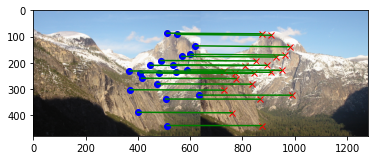

In [444]:
"""
Script (do not modify)
"""

# load images in OpenCV BGR format
I1 = cv2.imread('yosemite1.jpg')
I2 = cv2.imread('yosemite2.jpg')

# create grayscale images
I1_gray = cv2.cvtColor(I1, cv2.COLOR_BGR2GRAY)
I2_gray = cv2.cvtColor(I2, cv2.COLOR_BGR2GRAY)

# convert images to RGB format for display
I1 = cv2.cvtColor(I1, cv2.COLOR_BGR2RGB)
I2 = cv2.cvtColor(I2, cv2.COLOR_BGR2RGB)

# compute SIFT features
sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(I1_gray, None)
kp2, des2 = sift.detectAndCompute(I2_gray, None)

# match features
match, match_fwd, match_bkwd = match_features(des1, des2)

# get corresponding points p1, p2 
p1 = np.array([kp.pt for kp in kp1])[match[:, 0]]
p2 = np.array([kp.pt for kp in kp2])[match[:, 1]]

# plot first 20 matching points 
plot_corr(I1, I2, p1[:20], p2[:20])

In [445]:
'''
Function (modify)
'''
def ransac_homography(p1, p2):
  """
  p1, p2: N * 2, correponding point coordinates
  """
  
  # IMPLEMENT HERE
  
  # decide how many loops to run and what the threshold is

  # RANSAC loop, inside in the loop
  #     1. randomly pick n samples from p1 and p2 that is enough to fit a model(n=4 here)

  #     2. fit the model and get a estimation

  #     3. count consensus(# of inliners that is close to the estimatiion within the threshold)

  #     4. update the best estimation if the current one is better
  
  S = p1.shape[0]
  n = 4

  w = 0.5
  p = 1 - 1*(np.exp(-4)) #Desired Ransac success rate

  k = math.log(1-p)/math.log(1 - w**n) #number of iterations
  k = math.floor(k)

  t = 50
  inliers_prev = 0

  # RANSAC loop, inside in the loop
  for i in range(1000):
    indx = np.random.choice(S, n, replace = False)

    p1_s = p1[indx]
    p2_s = p2[indx]

    H_new = compute_homography(p1_s, p2_s) #Check which first

    p2_full = np.append(p2, np.ones(S).reshape(S,1), axis=1)
    p1_d = ((H_new@p2_full.T).T)[:,0:2]

    distances = np.linalg.norm(p1-p1_d, 2, axis=1).reshape(S,1)
    
    inliers = np.count_nonzero(distances<t)

    if inliers > inliers_prev:
      inliers_prev = inliers
      H = H_new
  
  return H 


In [446]:
## Test ##
p2 = np.random.randint(20, 200, size=(10, 2))
p2_ = np.hstack((p2, np.ones((10, 1)))).T
H = np.array([[ 6.76097539e-01,  9.12020085e-02,  2.61445474e+02],
       [-1.57581282e-01,  9.59039559e-01,  5.18593524e+00],
       [-4.93549913e-04,  9.67378471e-05,  1.00000000e+00]])
p1_ = H @ p2_
p1 = p1_ / p1_[-1, :]
p1 = p1[:2]
p1[:, -1] += 50
p1 = p1.T
assert np.allclose(H, ransac_homography(p1, p2))

In [451]:
"""
Function (do not modify)
"""
def stitch(I1, I2, H):
    """
    utility function to stitch two images

    Input:

    I1: H1 x W1 x 3, target image
    I2: H2 x W2 x 3, source image
    H: homography matrix such that I1 = H @ I2

    Output:
    I_: stitching result
    """


    nc, nr = I2.shape[1], I2.shape[0]
    x, y = np.meshgrid(np.arange(nc), np.arange(nr))

    Y_I2, X_I2 = I2.shape[:2] #Mapping i2 to I1

    
    # create new dimensions to accomodate points from I2
    #Corners
    I2_C1 = np.ones(3)
    I2_C2 = np.ones(3)
    I2_C3 = np.ones(3)
    I2_C4 = np.ones(3)

    I2_C1[:2] = [0, 0]
    I2_C2[:2] = [0, Y_I2]
    I2_C3[:2] = [X_I2, 0]
    I2_C4[:2] = [X_I2, Y_I2]

    X_max = None
    Y_max = None
    X_min = None
    Y_min = None

    #Corner points homography

    for p in [I2_C1, I2_C2, I2_C3, I2_C4]:
      I2_h = H @(np.array(p).T)
      I2_h = I2_h / I2_h[2]
      I2_h = I2_h[:2]

      I2_h = np.array(I2_h).reshape(I2_h.shape[0],1)
      if (X_max == None or I2_h[0,0] > X_max):
        X_max = I2_h[0,0]

      if (Y_max == None or I2_h[1,0] > Y_max):
        Y_max = I2_h[1,0]

      if (X_min == None or I2_h[0,0] < X_min):
        X_min = I2_h[0,0]

      if (Y_min == None or I2_h[1,0] < Y_min):
        Y_min = I2_h[1,0]

    X_min = min(0, X_min)
    Y_min = min(0, Y_min)

    X_min = int(X_min)
    Y_min = int(Y_min)
    X_max = int(X_max)
    Y_max = int(Y_max)

    I_i1 = np.zeros((Y_max - Y_min, X_max - X_min, 3))
    I_i2 = I_i1
    I_ = I_i1

    #Matrix translation

    T = np.array([[1, 0, X_min],
                 [0, 1, Y_min],
                 [0, 0, 1]])
    
    I_i1[abs(Y_min): abs(Y_min) + I1.shape[0], abs(X_min) : abs(X_min) + I1.shape[1], :] = I1

    #Making co-ordinate matrix final img

    Y_I_I2, X_I_I2 = I_i2.shape[:2]

    Y_grid, X_grid = np.meshgrid(np.arange(Y_I_I2), np.arange(X_I_I2))
    Y_grid_flatten = Y_grid.flatten()
    X_grid_flatten = X_grid.flatten()
    Y_grid_flatten = Y_grid_flatten.reshape(Y_grid_flatten.shape[0], 1)
    X_grid_flatten = X_grid_flatten.reshape(X_grid_flatten.shape[0], 1)
  

    I_i2_cord = np.hstack((X_grid_flatten , Y_grid_flatten, np.ones((X_grid_flatten.shape[0],1))))

    I_interp = T@I_i2_cord.T

    H_1 = np.linalg.inv(H)
    I_i2_hat = H_1 @ I_interp

    I_i2_hat = I_i2_hat / (I_i2_hat[2,:])
    I_i2_hat = I_i2_hat[:2, :].T


    X_I_i2_hat = I_i2_hat[:, 0]
    Y_I_i2_hat = I_i2_hat[:, 1]

    in_pts = np.where((X_I_i2_hat > 0) & (X_I_i2_hat < I2.shape[1]) & (Y_I_i2_hat > 0) & (Y_I_i2_hat < I2.shape[0]))


    X_I_i2_hat = X_I_i2_hat[in_pts]
    Y_I_i2_hat = Y_I_i2_hat[in_pts]
    X_grid_flatten = X_grid_flatten[in_pts]
    Y_grid_flatten = Y_grid_flatten[in_pts]

    I2_interp2 = np.zeros((X_grid_flatten.shape[0],3))
    I2_interp2[:, 0] = interp2(I2[:, :, 0], X_I_i2_hat, Y_I_i2_hat)
    I2_interp2[:, 1] = interp2(I2[:, :, 1], X_I_i2_hat, Y_I_i2_hat)
    I2_interp2[:, 2] = interp2(I2[:, :, 2], X_I_i2_hat, Y_I_i2_hat)

    for i in range(X_I_i2_hat.shape[0]):
      if (I_i1[Y_grid_flatten[i], X_grid_flatten[i],:].all() == 0):
        I_i1[Y_grid_flatten[i], X_grid_flatten[i], :] = I2_interp2[i]
      else:
        I_i1[Y_grid_flatten[i], X_grid_flatten[i], :] = (I_i1[Y_grid_flatten[i], X_grid_flatten[i], :] + I2_interp2[i]) / 2







    # map I_ to I2 (translation then homography)

    # keep only the valid coordinates of I2

    # in blend area, take the average of I1_ and I2_
    # I1_ = 
    # I2_
    return I_i1/255

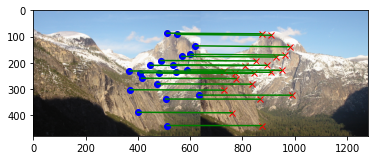

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


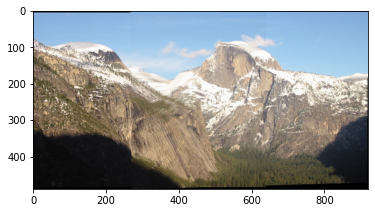

In [455]:
"""
Script (do not modify)
"""

# load images in OpenCV BGR format
I1 = cv2.imread('yosemite1.jpg')
I2 = cv2.imread('yosemite2.jpg')

# create grayscale images
I1_gray = cv2.cvtColor(I1, cv2.COLOR_BGR2GRAY)
I2_gray = cv2.cvtColor(I2, cv2.COLOR_BGR2GRAY)

# convert images to RGB format for display
I1 = cv2.cvtColor(I1, cv2.COLOR_BGR2RGB)
I2 = cv2.cvtColor(I2, cv2.COLOR_BGR2RGB)

# compute SIFT features
sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(I1_gray, None)
kp2, des2 = sift.detectAndCompute(I2_gray, None)

# match features
match, match_fwd, match_bkwd = match_features(des1, des2)

# print(match)

# get corresponding points p1, p2 
p1 = np.array([kp.pt for kp in kp1])[match[:, 0]]
p2 = np.array([kp.pt for kp in kp2])[match[:, 1]]

# print(p1)
# print(p2)

# plot first 20 matching points 
plot_corr(I1, I2, p1[:20], p2[:20])

# estimate homography transform with RANSAC
# print(p1.shape, p2.shape)
H = ransac_homography(p1, p2)

# stitch two images together and show the results
I = stitch(I1,I2,H)
plt.figure()
plt.imshow(I)
plt.show()